In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jaimetrickz_galaxy_zoo_2_images_path = kagglehub.dataset_download('jaimetrickz/galaxy-zoo-2-images')

print('Data source import complete.')


100%|██████████| 3.06G/3.06G [02:24<00:00, 22.7MB/s]

Extracting files...


Data source import complete.


In [ ]:
import kagglehub
path = kagglehub.dataset_download("jaimetrickz/galaxy-zoo-2-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jaimetrickz/galaxy-zoo-2-images/versions/1


In [ ]:
import os

DATA_DIR = '/root/.cache/kagglehub/datasets/jaimetrickz/galaxy-zoo-2-images/versions/1/images_gz2'


print(os.listdir(DATA_DIR)[:10])


['images']


We are going to make a normalization of (0.5)

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T


In [1]:
image_size = 64
batch_size=128
channels = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [ ]:
data = ImageFolder(DATA_DIR, transform = T.Compose([
    T.Resize(image_size),# we are making them into 64x64, making it a square is important
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*channels)]))


loader = DataLoader(data,batch_size,shuffle=True,num_workers=3,pin_memory=True)
print("done")

done


Now we are going to create a denorm funciton, and then functions to show images from dataset


In [19]:
def denorm(image_tensor):
    return image_tensor *0.5+0.5

In [20]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
%matplotlib inline

In [13]:
def show_images(images,nmax=64):
    fig,ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl,nmax=64):
    for images, _ in dl:
        show_images(images,nmax)
        break

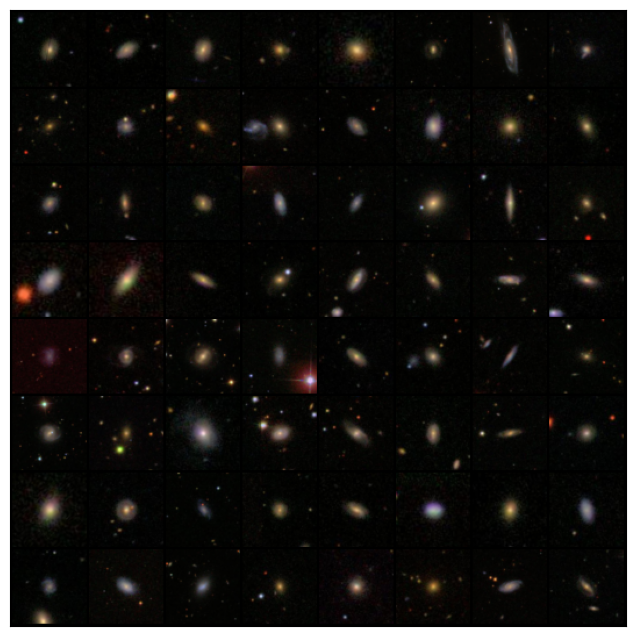

In [ ]:
show_batch(loader)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import torch.nn as nn

discriminator = nn.Sequential(

#in 3x64x64
nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
nn.BatchNorm2d(64),
nn.LeakyReLU(0.2,inplace=True),

#convblock 2
nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
nn.BatchNorm2d(128),
nn.LeakyReLU(0.2,inplace=True),
#convblock 3

nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
nn.BatchNorm2d(256),
nn.LeakyReLU(0.2,inplace=True),

nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
nn.BatchNorm2d(512),
nn.LeakyReLU(0.2,inplace=True),

nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias = False),


nn.Flatten(),
nn.Sigmoid()
)

In [ ]:
discriminator.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [5]:
import torch.nn as nn

Generator network:

The generator network will make a random tensor, (latent tensor), it will convert a latent tensor of (128,1,1) to a shape of (3,64,64), we will do this by using the Transpose2d layer from Pytorch.

In [7]:
latent_size = 128

In [8]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size =4,padding=0,stride=1,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # out 512x4x4
    nn.ConvTranspose2d(512,256,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    # out 256 x8x8
    nn.ConvTranspose2d(256,128,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    #out128x16x16

    nn.ConvTranspose2d(128,64,kernel_size = 4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    #64x32x32

    nn.ConvTranspose2d(64,3,kernel_size = 4,padding=1,stride=2,bias=False),
    nn.Tanh()
    #out 3,64x64

)

torch.Size([128, 3, 64, 64])


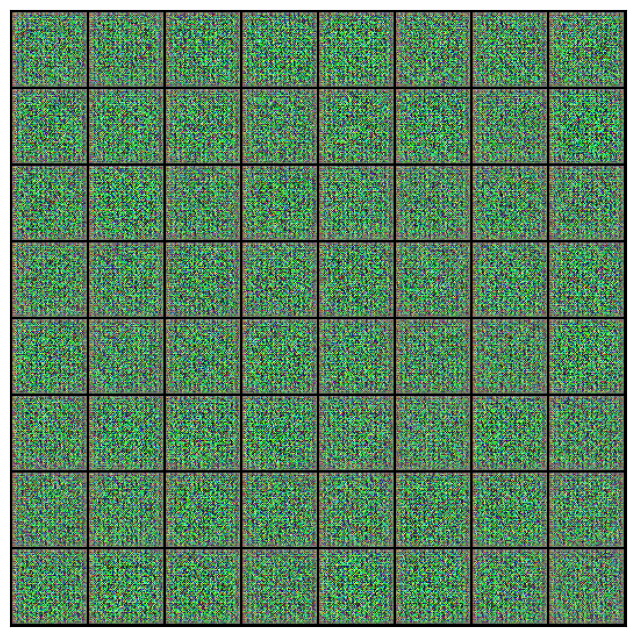

In [ ]:
xb = torch.randn(batch_size,latent_size,1,1)
fake_img = generator(xb)
print(fake_img.shape)
show_images(fake_img)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
from torchvision.utils import save_image

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones((real_images.size(0),1), device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros((fake_images.size(0),1), device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

steps in training the discriminator:

it outputs one for all real images produced by the model, use torch.ones() to get a real target, and then use binary_cross_entropy to get a lsoss

We pass a batch of real images and comput the loss, setting the target labels to 1

Then we pass a batch of fake images (using the generator) and then comput the loss, setting the target label to 0

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (opt_d only affects the discriminator.parameters())

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [ ]:
def train_generator(opt_g):

    opt_g.zero_grad()
    #generate the images
    latent = torch.randn(batch_size,latent_size, 1,1 ,device = device)
    gen_images = generator(latent)

    target = torch.ones((batch_size,1),device = device)
    d_preds = discriminator(gen_images)
    loss = F.binary_cross_entropy(d_preds,target)


    loss.backward()
    opt_g.step()

    return loss.item()






## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>


In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
generator = generator.to(device)
discriminator = discriminator.to(device)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    least_loss = 10000



    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(loader):
            real_images = real_images.to(device)

            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        if loss_g<least_loss:
          least_loss = loss_g
          torch.save(generator.state_dict(), "best_generator.pth")

        # Save generated images
        if epoch == 24:

          from google.colab import files
          files.download(str("best_generator.pth"))

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
epochs = 25
lr = 0.0002

In [ ]:
history = fit(lr = lr,epochs = epochs)

  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.9211, loss_d: 0.8967, real_score: 0.8859, fake_score: 0.5008


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 3.1123, loss_d: 0.4654, real_score: 0.8510, fake_score: 0.2382


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.1260, loss_d: 0.5853, real_score: 0.7357, fake_score: 0.2102


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 3.2805, loss_d: 0.4357, real_score: 0.8904, fake_score: 0.2536


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.9749, loss_d: 0.8759, real_score: 0.5105, fake_score: 0.0863


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 2.7714, loss_d: 0.3311, real_score: 0.9910, fake_score: 0.2452


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 2.6494, loss_d: 0.7605, real_score: 0.5468, fake_score: 0.0184


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 3.0747, loss_d: 0.4015, real_score: 0.7435, fake_score: 0.0550


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.5202, loss_d: 0.2520, real_score: 0.9573, fake_score: 0.1648


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 3.4624, loss_d: 0.3159, real_score: 0.8939, fake_score: 0.1606


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 2.7147, loss_d: 0.4184, real_score: 0.8071, fake_score: 0.1236


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 2.7963, loss_d: 1.0862, real_score: 0.4079, fake_score: 0.0007


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.3074, loss_d: 0.3438, real_score: 0.9303, fake_score: 0.2061


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 3.5634, loss_d: 0.3446, real_score: 0.8887, fake_score: 0.1585


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 3.2745, loss_d: 0.1491, real_score: 0.9553, fake_score: 0.0895


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.1395, loss_d: 0.4530, real_score: 0.9833, fake_score: 0.3050


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 3.9057, loss_d: 0.4704, real_score: 0.8777, fake_score: 0.2092


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 2.0358, loss_d: 0.2491, real_score: 0.8457, fake_score: 0.0454


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 7.1744, loss_d: 0.5473, real_score: 0.9572, fake_score: 0.3300


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.0846, loss_d: 7.1858, real_score: 0.0031, fake_score: 0.0000


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 2.3549, loss_d: 0.4731, real_score: 0.6960, fake_score: 0.0055


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 3.2437, loss_d: 0.1902, real_score: 0.8619, fake_score: 0.0197


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 3.8034, loss_d: 0.2199, real_score: 0.9642, fake_score: 0.1390


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 2.5135, loss_d: 0.4907, real_score: 0.6747, fake_score: 0.0066


  0%|          | 0/1902 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.4141, loss_d: 0.4977, real_score: 0.6647, fake_score: 0.0013


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(generator.state_dict())

TypeError: save() missing 1 required positional argument: 'f'

In [ ]:
from IPython.display import Image

Image('./generated/generated-images-0011.png')

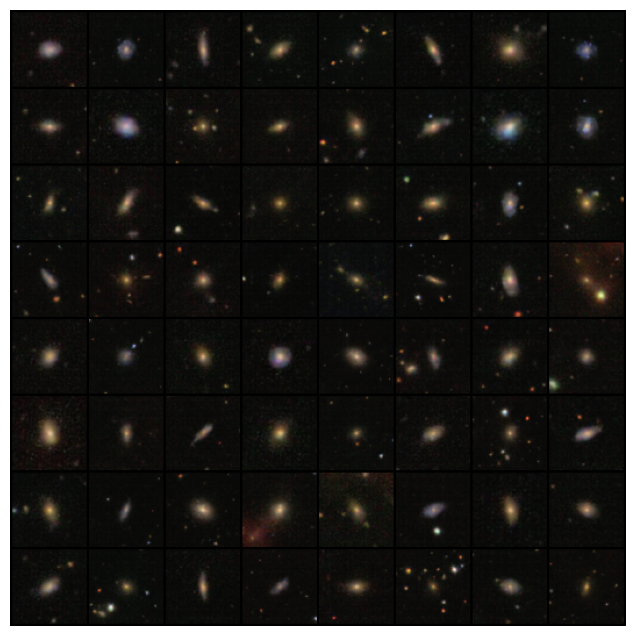

In [21]:
import torch

new_gen = generator
new_gen.load_state_dict(torch.load('best_generator.pth'))
new_gen = new_gen.to(device)
new_gen.eval()

latent_tensor = torch.randn(64, latent_size, 1, 1).to(device)
fake_images = new_gen(latent_tensor)

plt.figure(figsize=(8, 8))
plt.imshow(make_grid(denorm(fake_images.detach()), nrow=8).permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()